## Step 1: Let's Get Some Images

For the sake of practice I won't be using the API here and instead scraping from the game-level pages on plays.tv

In [1]:
import urllib
from bs4 import BeautifulSoup
import csv
import requests
import os
from IPython.display import clear_output
import numpy as np
import cv2
import math
import sklearn
from matplotlib import pyplot as plt
from PIL import Image
import random
%matplotlib inline

## Reusing some code from an earlier project to get images

This goes to the game page of plays.tv, and looks at a game index page - such as: https://plays.tv/game/CounterStrikeGlobalOffensive?game_id=04094bf1f162594b28707b50c4e8349e . It finds all 720 videos. We download the video, sample frames at once a seconds, and save the frames as 144 * 96 images

For the training itself we'll convert it into luminesence 

In [2]:
# Frames per Game
FRAME_LIMIT_TRAIN = 1000
FRAME_LIMIT_TEST = 100
# You can actually upload pretty huge videos to plays.tv
# These will dominate training + take forever
# We're going to limit it to ~25 MB
MAX_VIDEO_SIZE_CHUNKS = 100000

def downloadVideo(name, url):
    try:
        chunks = 0
        r=requests.get(url)
        f=open(name,'wb')
        for chunk in r.iter_content(chunk_size=255): 
            chunks += 1
            if chunks > MAX_VIDEO_SIZE_CHUNKS:
                return False
            if chunk: 
                f.write(chunk)
        f.close()
    except:
        print("Error downloading file")
        return False
    return True
    
def getScreenshotsFromFile(images, file_name, ms_interval, w, h, 
                           frames_train, frames_test):
    vidcap = cv2.VideoCapture(file_name)
    success, image = vidcap.read()
    # Keep track of frames in video to sample once/second
    # Using cv2.CAP_PROP_POS_MSEC
    count = 0

    while success and frames_test < FRAME_LIMIT_TEST:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*ms_interval))
        # If we want to save the image to disk, use 
        # cv2.imwrite('./playstvscreenshots/video{}frame{}.jpg'.format(
        #    str(n), 
        #    str(count)), 
        #   image)
        if frames_train < FRAME_LIMIT_TRAIN:   
            images['train'][key].append(cv2.resize(image,(w,h)))
            frames_train += 1
            if frames_train == FRAME_LIMIT_TEST:
                return images
        elif frames_test < FRAME_LIMIT_TEST:
            images['test'][key].append(cv2.resize(image,(w, h)))
            frames_test += 1
            if frames_test == FRAME_LIMIT_TEST:
                return images
            
        success,image = vidcap.read()
        count += 1
        
    return images
           
    
base_urls = {
    "csgo" : "https://plays.tv/game/CounterStrikeGlobalOffensive?game_id=04094bf1f162594b28707b50c4e8349e&page={}",
    "gta5" : "https://plays.tv/game/GrandTheftAutoV?game_id=65514104855d11e3aebc655d44bec87b&page={}",
    "dota2" : "https://plays.tv/game/Dota2?game_id=e9af38482c77a80a0688bbcab98a933f&page={}",
    "rs6" : "https://plays.tv/game/TomClancysRainbowSixSiege?game_id=114cdf56f27611e3a930b04744bec87b&page={}",
    "pubg" : "https://plays.tv/game/PLAYERUNKNOWNSBATTLEGROUNDS?game_id=beab9bd40164e6ed6101d7e0914b59e1&page={}",
    "fortnite" : "https://plays.tv/game/Fortnite?game_id=98ff5053ea366a4965ba7dbcfa10670c&page={}",
    "league" : "https://plays.tv/game/LeagueofLegends?game_id=b179585c6b68a2791eea4a1ad3d7ef72&page={}",
    "overwatch" : "https://plays.tv/game/Overwatch?game_id=101652c2d97f9a8d8872e7450f7daae6&sort=sort_popular&page={}"
}

if not os.path.exists('./playstvclips'):
    os.mkdir('playstvclips')
if not os.path.exists('./playstvscreenshots'):
    os.mkdir('playstvscreenshots')

images = {}
images['train'] = {}
images['test'] = {}

for key in base_urls.keys():
    images['train'][key] = []
    images['test'][key] = []
    video_counter = 0
    frames_train = 0
    frames_test = 0

    base_url = base_urls[key]

    for pages in range(10):
        # if we're done getting images, carry on - this range is just a sanity check 
        if frames_test >= FRAME_LIMIT_TEST:
            continue
        
        # get all the links in page N
        page = base_url.format(str(pages))
        page_data = urllib.request.urlopen(page)
        soup = BeautifulSoup(page_data, "html.parser")
        urls = soup.findAll('source', limit=200)

        # Use 720/480 links to save on download size 
        for url in [url for url in urls if '720' in url['src'] or '480' in url['src']]:
            # Same as above, skip to end of page
            if frames_test >= FRAME_LIMIT_TEST:
                continue
                
            # Status Check for Display
            video_counter += 1
            clear_output(wait=True)
            print(key + ' ' + str(video_counter))
            print("Frames = {} / {}".format(frames_train+frames_test, 
                                            FRAME_LIMIT_TRAIN+FRAME_LIMIT_TEST)
                )
            
            # For VideoCapture to work it needs to be on disk,
            # So we download the video
            this_url = url['src'].replace('//', 'http://')
            file_name = './playstvclips/'+key+str(video_counter)+'.mp4'
            
            if downloadVideo(file_name, this_url):
                images = getScreenshotsFromFile(images, 
                                                file_name, 
                                                ms_interval=1000,
                                                w=144,
                                                h=96,
                                                frames_train=frames_train,
                                                frames_test=frames_test)
                frames_train = len(images['train'][key])
                frames_test = len(images['test'][key])


overwatch 40
Frames = 1083 / 1100


## We should now have a dictionary keyed on game name with an array of images as the value

Let's check the first entries

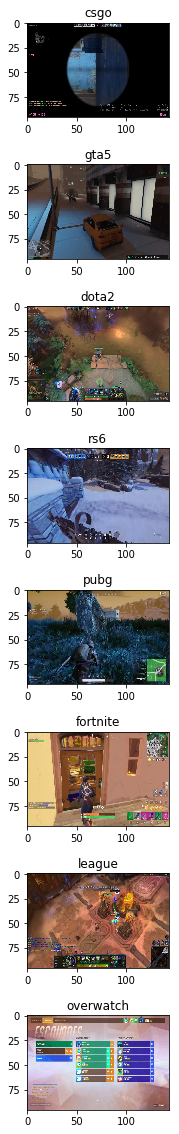

In [3]:
games = len(base_urls.keys())
fig = plt.figure(figsize=(games*50, 20))
fig.subplots_adjust(hspace=.5)
for idx, key in enumerate(base_urls.keys()):
    fig.add_subplot(games, 1, idx+1)
    plt.title(key)
    plt.imshow(images['train'][key][0])

In [4]:
print("Check record counts")
for g in base_urls.keys():
    print("{} - Train: {} Test: {}".format(g, len(images['train'][g]), len(images['test'][g])))

Check record counts
csgo - Train: 1000 Test: 100
gta5 - Train: 1000 Test: 100
dota2 - Train: 1000 Test: 100
rs6 - Train: 1000 Test: 100
pubg - Train: 1000 Test: 100
fortnite - Train: 1000 Test: 100
league - Train: 1000 Test: 100
overwatch - Train: 1000 Test: 100


## OK! ML Time.

For starters let's use Tensorflow's Keras API to train a multilayer network (conv2d->dense) and see how well it can differentiate these!


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.VERSION)
print(tf.keras.__version__)
from tensorflow.keras.models import *
from tensorflow.keras.layers import  *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical


1.12.0
2.1.6-tf


In [6]:
print("We have {} games".format(games))

We have 8 games


In [7]:
# Simple Model
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[96, 144, 1]))
model.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=50, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=80, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(games,activation='softmax'))


model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## We're going to transform the data

I could do this a bit more neatly and I could clean it up later. 

Additionally, we could save the images locally and do transforms with the keras utils. I'm not sure if this is worth doing as the game images should be dimensionally/rotationally static. 

In [15]:
# turn an array of images in to luminosity values
def grey(images):
    return [np.asarray(Image.fromarray(i).convert('L')) for i in images]

raw_train_data = []
raw_test_data = []
raw_train_labels= []
raw_test_labels = []

game_map = dict(zip(list(base_urls.keys()), range(games)))
game_map_inv = {v: k for k, v in game_map.items()}

for game in list(base_urls.keys()):
    raw_train_data += images['train'][game]
    raw_train_labels += [game_map[game]] * len(images['train'][game])
    raw_test_data += images['test'][game]
    raw_test_labels += [game_map[game]] * len(images['test'][game])

base_train_data = grey(raw_train_data)
base_test_data = grey(raw_test_data)                            
                                 
train_data = np.array(base_train_data).reshape(-1, 96, 144, 1)
train_labels = to_categorical(raw_train_labels, num_classes=games)
test_data = np.array(base_test_data).reshape(-1, 96, 144, 1)
test_labels = to_categorical(raw_test_labels, num_classes=games)

## Let's fit the model and evaluate it on some data we held out from training

In [9]:
model.fit(train_data, train_labels, epochs = 15, batch_size=64)

Epoch 1/15
8000/8000 [==============================] - 57s 7ms/step - loss: 2.9996 - acc: 0.3995
Epoch 2/15
8000/8000 [==============================] - 58s 7ms/step - loss: 0.3739 - acc: 0.8845
Epoch 3/15
8000/8000 [==============================] - 53s 7ms/step - loss: 0.1263 - acc: 0.9622
Epoch 4/15
8000/8000 [==============================] - 53s 7ms/step - loss: 0.0687 - acc: 0.9790
Epoch 5/15
8000/8000 [==============================] - 54s 7ms/step - loss: 0.0496 - acc: 0.9846
Epoch 6/15
8000/8000 [==============================] - 54s 7ms/step - loss: 0.0389 - acc: 0.9873
Epoch 7/15
8000/8000 [==============================] - 57s 7ms/step - loss: 0.0287 - acc: 0.9904
Epoch 8/15
8000/8000 [==============================] - 55s 7ms/step - loss: 0.0330 - acc: 0.9899
Epoch 9/15
8000/8000 [==============================] - 55s 7ms/step - loss: 0.0310 - acc: 0.9892
Epoch 10/15
8000/8000 [==============================] - 55s 7ms/step - loss: 0.0186 - acc: 0.9944
Epoch 11/15
8000/80

In [10]:
outputs = model.evaluate(test_data, test_labels, batch_size=32)
outputs = list(zip(model.metrics_names, outputs))
for o in outputs:
    print("{} : {}".format(o[0], o[1]))

800/800 [==============================] - 2s 2ms/step
loss : 0.0070704968016002566
acc : 0.99625


## Let's look at some test examples

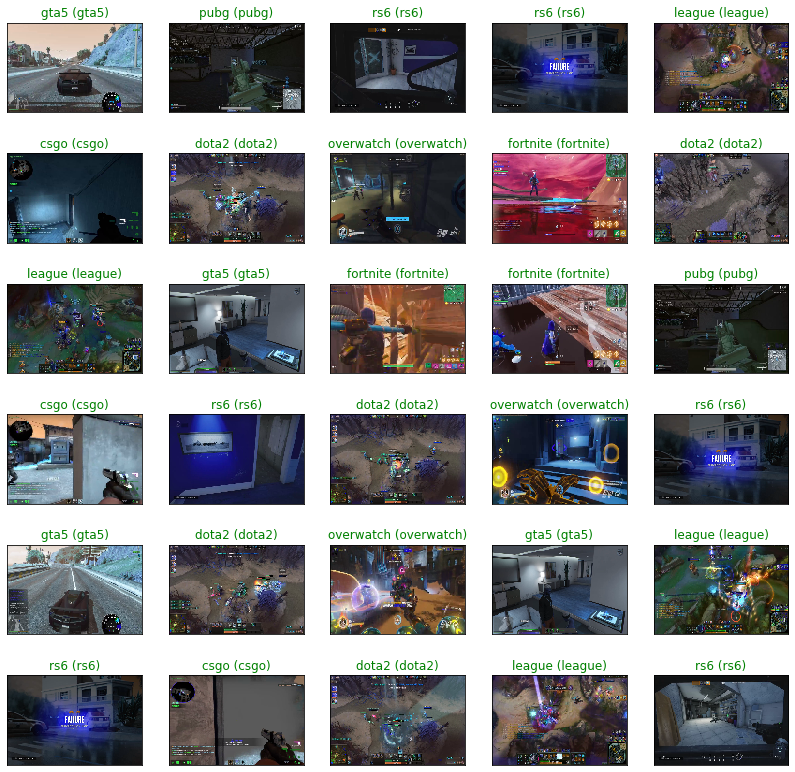

In [19]:
fig = plt.figure(figsize=(14,14))
for idx, i in enumerate(np.random.randint(FRAME_LIMIT_TEST*games, size=30)):
    image = raw_test_data[i]
    this_class = game_map_inv[np.argmax(classes[i])]
    subplot = fig.add_subplot(6, 5, idx+1)
    subplot.imshow(image)
    title_color = 'red'
    if (this_class == game_map_inv[raw_test_labels[i]]):
        title_color = 'green'
    title = plt.title(this_class + ' ({})'.format(game_map_inv[raw_test_labels[i]]))
    plt.setp(title, color=title_color)
    subplot.get_yaxis().set_visible(False)
    subplot.get_xaxis().set_visible(False)
    

## What went wrong?

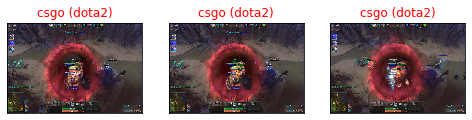

In [33]:
fig = plt.figure(figsize=(14,14))
j = 0 
for i in range(FRAME_LIMIT_TEST*games):
    image = raw_test_data[i]
    if np.argmax(classes[i]) == raw_test_labels[i]:
        continue
    j += 1
    this_class = game_map_inv[np.argmax(classes[i])]
    subplot = fig.add_subplot(6, 5, j+1)
    subplot.imshow(image)
    title_color = 'red'
    if (this_class == game_map_inv[raw_test_labels[i]]):
        title_color = 'green'
    title = plt.title(this_class + ' ({})'.format(game_map_inv[raw_test_labels[i]]))
    plt.setp(title, color=title_color)
    subplot.get_yaxis().set_visible(False)
    subplot.get_xaxis().set_visible(False)
    